## Parsing and Processing Kraken Results

### Identify the target species and potential contaminants from the taxonomic classification from Kraken output

In [9]:
import pandas as pd

#kraken output file
filename = 'ecol+tb_rishika_kraken.txt'

df = pd.read_csv(filename, delimiter='\t', skiprows=2, header=0)

def strip_whitespace(x):
    return x.strip() if isinstance(x, str) else x
df = df.applymap(strip_whitespace)

#pre-processing: filling values of rank
df.loc[(df['rank'] == 'no rank') & df['taxName'].str.contains('str'),'rank'] = 'strain'
df.loc[(df['rank'] == 'no rank') & df['taxName'].str.contains('group'),'rank'] = 'kingdom'

print(df)

         %  reads  taxReads  kmers  dup           cov    taxID           rank  \
0   18.180      4         4    848    1  9.880000e-05        0        no rank   
1   81.820     18         0     32    1  4.830000e-08        1        no rank   
2   81.820     18         0     32    1  4.898000e-08   131567        no rank   
3   81.820     18         0     32    1  5.067000e-08        2   superkingdom   
4   72.730     16         0     27    1  8.498000e-08     1224         phylum   
5   72.730     16         0     27    1  1.766000e-07     1236          class   
6   72.730     16         1     27    1  6.425000e-07    91347          order   
7   68.180     15        12     26    1  1.248000e-06      543         family   
8   13.640      3         0      5    1  2.344000e-06      561          genus   
9   13.640      3         3      5    1  2.987000e-06      562        species   
10   9.091      2         0      5    1  2.057000e-08  1783272        kingdom   
11   9.091      2         0 

In [10]:
# Sort the DataFrame by rank specificity and coverage
rank_order = ['domain','superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species group','species', 'strain', 'no rank']
rank_index = {rank: index for index, rank in enumerate(rank_order)}
df['rank_index'] = df['rank'].map(rank_index)

df_sorted = df.sort_values(by=['rank_index', 'cov'], ascending=[True, False])
print(df_sorted)

         %  reads  taxReads  kmers  dup           cov    taxID           rank  \
3   81.820     18         0     32    1  5.067000e-08        2   superkingdom   
10   9.091      2         0      5    1  2.057000e-08  1783272        kingdom   
4   72.730     16         0     27    1  8.498000e-08     1224         phylum   
11   9.091      2         0      5    1  4.444000e-08   201174         phylum   
5   72.730     16         0     27    1  1.766000e-07     1236          class   
12   9.091      2         0      5    1  4.575000e-08     1760          class   
6   72.730     16         1     27    1  6.425000e-07    91347          order   
13   9.091      2         0      5    1  1.745000e-07    85007          order   
7   68.180     15        12     26    1  1.248000e-06      543         family   
14   9.091      2         0      5    1  4.098000e-07     1762         family   
8   13.640      3         0      5    1  2.344000e-06      561          genus   
15   9.091      2         0 

In [11]:
# Filter to the lowest rank index (max score)
lowest_rank_index = df['rank_index'].nlargest(3).unique()
df_lowest_rank = df[df['rank_index'].isin(lowest_rank_index)]
print(df_lowest_rank)

# Identify the target species based on the highest coverage
target_row = df_lowest_rank.sort_values(by='cov', ascending=False).iloc[0]
target_species_name = target_row['taxName']
target_species_id = target_row['taxID']
print(f"Target species: {target_species_name} (TaxID: {target_species_id})")


#TO DO: Need to figure out how to identify sequence IDs from Kraken results
kraken_contaminants = []
# Identify potential contaminants
for index, row in df_lowest_rank.iterrows():
    if row['taxName'] != target_species_name:
        kraken_contaminants.append('taxName')
        print(f"Potential contaminant found: {row['taxName']} (TaxID: {row['taxID']})")

       %  reads  taxReads  kmers  dup           cov   taxID     rank  \
0  18.18      4         4    848    1  9.880000e-05       0  no rank   
1  81.82     18         0     32    1  4.830000e-08       1  no rank   
2  81.82     18         0     32    1  4.898000e-08  131567  no rank   

              taxName  rank_index  
0        unclassified          11  
1                root          11  
2  cellular organisms          11  
Target species: unclassified (TaxID: 0)
Potential contaminant found: root (TaxID: 1)
Potential contaminant found: cellular organisms (TaxID: 131567)


## Exploring Custom built Database-free Approaches

### GC content, simple k-mer profiling + clustering

In [12]:
def calculate_gc_content(sequence):
    gc_count = sum(1 for base in sequence if base in ["G", "C"])
    return gc_count / len(sequence) * 100

def parse_fasta(filename):
    with open(filename, 'r') as file:
        sequences = {}
        sequence_ids = []
        current_seq = ''
        current_id = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if current_id:
                    sequences[current_id] = current_seq
                    sequence_ids.append(current_id)
                current_id = line[1:]
                current_seq = ''
            else:
                current_seq += line
        if current_id:
            sequences[current_id] = current_seq
            sequence_ids.append(current_id)
        return sequences, sequence_ids

fasta_path = 'ecoli+tb_rishika.fasta'
sequences, sequence_ids = parse_fasta(fasta_path)

# Calculate GC content for each sequence
gc_contents = {seq_id: calculate_gc_content(seq) for seq_id, seq in sequences.items()}

# Identify sequences with atypical GC content (e.g., outside typical range)
typical_gc_range = (40, 60)  # Adjust range: currently set to prokaryotic range
atypical_gc_sequences = [seq_id for seq_id, gc in gc_contents.items() 
                         if not (typical_gc_range[0] <= gc <= typical_gc_range[1])]

print(atypical_gc_sequences)

['seq1', 'seq6', 'seq12', 'seq16']


In [13]:
from collections import Counter
import itertools
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def generate_all_kmers(k_size):
    """Generate all possible k-mers for a given size and alphabet."""
    alphabet = ['A', 'T', 'G', 'C']
    return [''.join(kmer) for kmer in itertools.product(alphabet, repeat=k_size)]

def generate_kmer_profile(sequence, all_kmers):
    """Generate a k-mer profile for a given sequence using a fixed set of k-mers."""
    kmer_counts = {kmer: 0 for kmer in all_kmers}
    for i in range(len(sequence) - k_size + 1):
        kmer = sequence[i:i + k_size]
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
    return list(kmer_counts.values())


def parse_fasta(filename):
    with open(filename, 'r') as file:
        sequences = {}
        sequence_ids = []
        current_seq = ''
        current_id = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if current_id:
                    sequences[current_id] = current_seq
                    sequence_ids.append(current_id)
                current_id = line[1:]
                current_seq = ''
            else:
                current_seq += line
        if current_id:
            sequences[current_id] = current_seq
            sequence_ids.append(current_id)
        return sequences, sequence_ids

def cluster_sequences(kmer_profiles, sequence_ids, k_size, n_clusters=2):
    # No need to regenerate kmer_profiles; they are already provided as input
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(kmer_profiles)

    # Scatter plot of the k-mer profiles colored by cluster label
    plt.scatter(np.array(kmer_profiles)[:, 0], np.array(kmer_profiles)[:, 1], c=labels)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('K-mer Profile Clustering')

    # Annotate each point with its sequence ID
    for i, txt in enumerate(sequence_ids):
        plt.annotate(txt, (np.array(kmer_profiles)[i, 0], np.array(kmer_profiles)[i, 1]))

    plt.show()

    # Map labels to sequence IDs
    labeled_sequences = {sequence_id: label for sequence_id, label in zip(sequence_ids, labels)}

    # Group sequences by cluster
    clusters = {i: [] for i in range(n_clusters)}
    for sequence_id, label in labeled_sequences.items():
        clusters[label].append(sequence_id)

    # Print out the sequences in each cluster
    for cluster_id, sequence_ids in clusters.items():
        print(f"Cluster {cluster_id}:")
        for seq_id in sequence_ids:
            print(f" - Sequence ID: {seq_id}")

    return labels, clusters


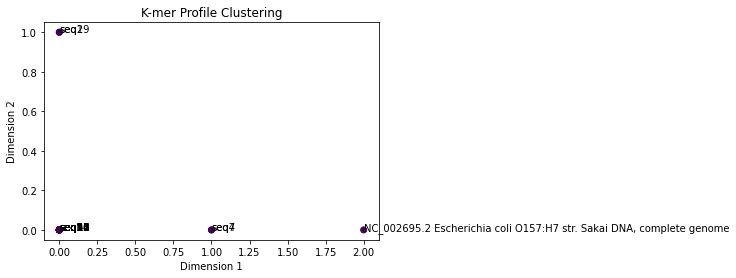

Cluster 0:
 - Sequence ID: NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome
 - Sequence ID: seq1
 - Sequence ID: seq2
 - Sequence ID: seq4
 - Sequence ID: seq5
 - Sequence ID: seq6
 - Sequence ID: seq7
 - Sequence ID: seq8
 - Sequence ID: seq9
 - Sequence ID: seq10
 - Sequence ID: seq11
 - Sequence ID: seq12
 - Sequence ID: seq13
 - Sequence ID: seq14
 - Sequence ID: seq15
 - Sequence ID: seq16
 - Sequence ID: seq17
 - Sequence ID: seq18
 - Sequence ID: seq19
 - Sequence ID: seq20
 - Sequence ID: seq21
Cluster 1:
 - Sequence ID: seq3


In [14]:

sequences, sequence_ids = parse_fasta(fasta_path)
# Generate all possible k-mers
k_size = 6
all_kmers = generate_all_kmers(k_size)

# Generate k-mer profiles for all sequences
kmer_profiles = [generate_kmer_profile(seq, all_kmers) for seq in sequences.values()]
labels = cluster_sequences(kmer_profiles, sequence_ids ,k_size=6)

## Parsing and Processing PhylOligo Results

### Getting cluster sequences from distance matrix produced by PhylOligo

/Users/rishika/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rishika/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


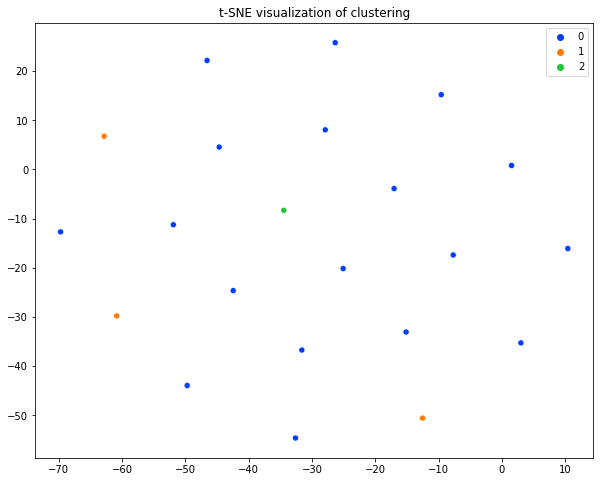

In [15]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 

# Load the distance matrix
distance_matrix = np.loadtxt('ecoli+tb_rishika_phyl.txt')

# Perform clustering
clusterer = KMeans(n_clusters=3)  
cluster_labels = clusterer.fit_predict(distance_matrix)

# Perform t-SNE for visualization
perplexity_value = min(30, len(sequences) - 1)
tsne = TSNE(metric='precomputed', random_state=42, perplexity = perplexity_value)
embedded = tsne.fit_transform(distance_matrix)

# Plot t-SNE results with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1], hue=cluster_labels, palette='bright')
plt.title('t-SNE visualization of clustering')
plt.show()

In [16]:
cluster_counts = Counter(cluster_labels)

# Determine the most common cluster (the cluster with the highest count)
most_common_cluster = cluster_counts.most_common(1)[0][0]

# Identify potential contaminants
# These are sequences whose cluster label is not the most common cluster label
phyloligo_contaminants = [sequence_ids[i] for i, cluster in enumerate(cluster_labels) if cluster != most_common_cluster]
print(phyloligo_contaminants)

['NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome', 'seq1', 'seq3', 'seq4']


## Analysis and Confidence from Results of both Algorithms

In [17]:
#TO-DO: Logic to combine the results of phyloligo and kraken to determine confidence of contaminants

phyloligo_set = set(phyloligo_contaminants)
kraken_set = set(kraken_contaminants)

print(phyloligo_set)

# Get the intersection of the two sets
common_contaminants = phyloligo_set.intersection(kraken_set)

print(common_contaminants)

{'seq1', 'seq3', 'seq4', 'NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome'}
set()
